In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd gdrive/MyDrive/AAU_Project/Goal_Oriented_Federated_Learning/

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/MyDrive/AAU_Project/Goal_Oriented_Federated_Learning


In [2]:
!pip install wandb -qU

In [3]:
# imports
import wandb

wandb.login()

import torch
import torch.nn as nn
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from copy import deepcopy
from tqdm import tqdm
from itertools import chain, combinations
from math import comb
import pickle
import os

from data_preprocess import (
    load_mnist_flat,
    load_cifar10,
    NIIDClientSplit,
    synthetic_samples,
)
from model import NN, CNN
from dshap import convergenceTest

wandb: Currently logged in as: pringlesinghal. Use `wandb login --relogin` to force relogin


In [4]:
os.makedirs("./processed_data/mnist/", exist_ok=True)
os.makedirs("./processed_data/cifar10/", exist_ok=True)
os.makedirs("./processed_data/mnist_flat/", exist_ok=True)
os.makedirs("./processed_data/cifar10_flat/", exist_ok=True)

# global variables
wandb_config = {}
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = "meta"
wandb_config["device"] = device


## Client

In [5]:
class Client:
    def __init__(self, data, targets, device):
        self.data = data.to(device)
        self.targets = targets.to(device)
        self.device = device
        self.length = len(self.data)

    def train(self, serverModel, criterion, E, B, learning_rate, momentum):
        """
        serverModel - server model
        criterion - loss function (model, data, targets)
        E - number of epochs
        B - number of batches

        returns clientModel.state_dict() after training
        """
        clientModel = deepcopy(serverModel)
        clientModel = clientModel.to(self.device)
        clientModel.load_state_dict(serverModel.state_dict())
        clientOptimiser = optim.SGD(
            clientModel.parameters(), lr=learning_rate, momentum=momentum
        )

        for epoch in range(E):
            batch_indices = self.split_indices(B)
            for batch in range(B):
                data_batch, targets_batch = self.get_subset(batch_indices[batch])
                clientOptimiser.zero_grad()
                loss = criterion(clientModel, data_batch, targets_batch)
                loss.backward()
                clientOptimiser.step()

        self.model = clientModel
        return clientModel.state_dict()

    def loss(self, model, criterion):
        """
        criterion - loss function (model, data, targets)
        """
        model.eval()
        with torch.no_grad():
            loss = criterion(model, self.data, self.targets)
        model.train()
        return float(loss.cpu())

    def accuracy(self):
        return self.accuracy_(self.model)

    def accuracy_(self, model):
        """
        evaluate model accuracy on client's training data
        """
        model.eval()
        with torch.no_grad():
            scores = model(self.data)
            _, predictions = scores.max(1)
            num_correct = torch.sum(predictions == self.targets)
            total = self.length
            accuracy = num_correct / total
        model.train()
        return float(accuracy.cpu())

    def get_subset(self, indices):
        """
        return a subset of client data and targets with the given indices
        """
        data_raw = [self.data[j] for j in indices]
        targets_raw = [int(self.targets[j]) for j in indices]
        # prepare data and targets for training
        data = torch.stack(data_raw, 0).to(device=self.device).to(torch.float32)
        targets = torch.tensor(targets_raw).to(device=self.device)
        return data, targets

    def split_indices(self, B):
        """
        return a list of indices for B batches
        """
        length = self.length
        indices = list(range(length))
        np.random.shuffle(indices)
        k = int(np.floor(length / B))
        # drops the last few datapoints, if needed, to keep batch size fixed
        return [indices[i : i + k] for i in range(0, len(indices), k)]




## Server

In [6]:
class Server:
    def __init__(self, model, val_data, val_targets, test_data, test_targets, device):
        self.model = deepcopy(model).to(device)
        self.val_data = val_data.to(device=device)
        self.val_targets = val_targets.to(device=device)
        self.test_data = test_data.to(device=device)
        self.test_targets = test_targets.to(device=device)
        self.length = len(test_data)
        self.device = device

        # to keep track of the number of model validation loss evaluations for shapley algorithms
        self.model_evaluations = 0
    def aggregate(self, client_states, weights=None):
        """
        client_states - list of client states
        weights - weights for averaging (uniform by default)

        updates server model by performing weighted averaging
        """
        model = self.aggregate_(client_states, weights)
        self.model.load_state_dict(model.state_dict())

    def aggregate_(self, client_states, weights=None):
        """
        does not modify the server model
        only returns the updated model
        """
        if weights is None:
            # uniform weights by default
            weights = [1 / len(client_states)] * len(client_states)
        weights = np.array(weights)
        wtsum = np.sum(weights)
        weights = weights / wtsum  # normalize weights
        # initialise model parameters to zero
        model_state = self.model.state_dict()
        for key in model_state.keys():
            model_state[key] -= model_state[key]
        # find updated model - weighted averaging
        for idx, client_state in enumerate(client_states):
            for key in model_state.keys():
                model_state[key] += weights[idx] * client_state[key]
        model = deepcopy(self.model).to(device=self.device)
        model.load_state_dict(model_state)
        return model

    def shapley_values_mc(self, criterion, client_states, weights=None):
        """
        client_states - list of client states
        weights - weights for averaging (uniform by default)

        computes shapley values for the client updates on validation dataset
        """
        self.model_evaluations = 0
        if weights is None:
            # uniform weights by default
            weights = [1 / len(client_states)] * len(client_states)
        weights = np.array(weights)
        wtsum = np.sum(weights)
        weights = weights / wtsum  # normalize weights

        num_clients = len(client_states)
        T = 100

        shapley_values = [[0] for i in range(num_clients)]

        for idx in range(num_clients):
            # compute shapley value of idx client
            """
            until convergence:
                sample a subset size k
                sample subset of size k of clients (except idx)
                compute updated model with this subset of clients
                compute loss of updated model on validation set
                compute another updated model with the idx client included
                compute loss of updated model on validation set
                compute difference between losses of the two models
                average losses over subsets to compute the shapley value of idx client
            """
            t = 0
            converged = False
            remaining_clients = [i for i in range(num_clients) if i != idx]
            while t < T:
                subset_size = np.random.choice(list(range(num_clients - 1)), size=1)[0]
                subset = np.random.choice(
                    remaining_clients, size=subset_size, replace=False
                )
                client_states_subset = [client_states[i] for i in subset]
                weights_subset = [weights[i] for i in subset]
                model_subset = self.aggregate_(client_states_subset, weights_subset)
                loss_subset = self.val_loss(model_subset, criterion)
                value_subset = 1- loss_subset

                client_states_subset.append(client_states[idx])
                weights_subset.append(weights[idx])
                model_subset_with_idx = self.aggregate_(
                    client_states_subset, weights_subset
                )
                loss_subset_with_idx = self.val_loss(model_subset_with_idx, criterion)
                value_subset_with_idx = 1 - loss_subset_with_idx

                utility_gain = value_subset_with_idx - value_subset
                prev_avg = shapley_values[idx][-1]
                new_avg = (t * prev_avg + utility_gain) / (t + 1)
                shapley_values[idx].append(new_avg)
                if convergenceTest(shapley_values[idx]):
                    converged = True
                t += 1
        if converged == False:
          print('SV not converged in MC')
        final_shapley_values = [shapley_values[i][-1] for i in range(num_clients)]
        return final_shapley_values

    def shapley_values_tmc(self, criterion, client_states, weights=None):
        """
        client_states - list of client states
        weights - weights for averaging (uniform by default)

        computes shapley values for the client updates on validation dataset
        """
        self.model_evaluations = 0
        if weights is None:
            # uniform weights by default
            weights = [1 / len(client_states)] * len(client_states)
        weights = np.array(weights)
        wtsum = np.sum(weights)
        weights = weights / wtsum  # normalize weights

        num_clients = len(client_states)

        shapley_values = [[0] for i in range(num_clients)]
        converged = False

        T = 50 * num_clients
        t = 0
        threshold = 1e-3
        v_init = 1 - self.val_loss(self.model, criterion)  # initial server model loss
        model_final = self.aggregate_(client_states, weights)
        v_final = 1 - self.val_loss(model_final, criterion)  # final server model loss
        while not converged and (t < T):
            t += 1
            client_permutation = np.random.permutation(num_clients)
            v_j = v_init
            for j in range(num_clients):
                if np.abs(v_final - v_j) < threshold:
                    v_jplus1 = v_j
                else:
                    subset = client_permutation[: (j + 1)]
                    client_states_subset = [client_states[i] for i in subset]
                    weights_subset = [weights[i] for i in subset]
                    model_subset = self.aggregate_(client_states_subset, weights_subset)
                    v_jplus1 = 1 - self.val_loss(model_subset, criterion)

                phi_old = shapley_values[client_permutation[j]][-1]
                phi_new = ((t - 1) * phi_old + (v_jplus1 - v_j)) / t
                shapley_values[client_permutation[j]].append(phi_new)
                v_j = v_jplus1

            flag = True
            for j in range(num_clients):
                if not convergenceTest(shapley_values[j]):
                    flag = False
            if flag:
                converged = True
        if converged == False:
          print('not converged in SV TMC')
        final_shapley_values = [shapley_values[i][-1] for i in range(num_clients)]
        print(f'SV_TMC = {final_shapley_values}')
        return final_shapley_values

    def shapley_values_gtg(self, criterion, client_states, weights=None):
        """
        client_states - list of client states
        weights - weights for averaging (uniform by default)

        computes shapley values for the client updates on validation dataset
        """
        self.model_evaluations = 0
        if weights is None:
            # uniform weights by default
            weights = [1 / len(client_states)] * len(client_states)
        weights = np.array(weights)
        wtsum = np.sum(weights)
        weights = weights / wtsum  # normalize weights

        num_clients = len(client_states)

        shapley_values = [[0] for i in range(num_clients)]
        converged = False

        T = 50 * num_clients
        t = 0
        threshold = 1e-3
        v_init = 1 - self.val_loss(self.model, criterion)  # initial server model loss
        model_final = self.aggregate_(client_states, weights)
        v_final = 1 - self.val_loss(model_final, criterion)  # final server model loss
        if np.abs(v_final - v_init) < threshold:
            # between round truncation
            return [0 for i in range(num_clients)]

        while not converged and (t < T):
            for client_idx in range(num_clients):
                t += 1
                client_permutation = np.concatenate(
                    (
                        np.array([client_idx]),
                        np.random.permutation(
                            [i for i in range(num_clients) if i != client_idx]
                        ),
                    )
                ).astype(int)
                v_j = v_init
                for j in range(num_clients):
                    if np.abs(v_final - v_j) < threshold:
                        v_jplus1 = v_j
                    else:
                        subset = client_permutation[: (j + 1)]
                        client_states_subset = [client_states[i] for i in subset]
                        weights_subset = [weights[i] for i in subset]
                        model_subset = self.aggregate_(client_states_subset, weights_subset)
                        v_jplus1 = 1 - self.val_loss(model_subset, criterion)

                    phi_old = shapley_values[client_permutation[j]][-1]
                    phi_new = ((t - 1) * phi_old + (v_jplus1 - v_j)) / t
                    shapley_values[client_permutation[j]].append(phi_new)
                    v_j = v_jplus1

                flag = True
                for j in range(num_clients):
                    if not convergenceTest(shapley_values[j]):
                        flag = False
                if flag:
                    converged = True
        if converged == False:
          print('not converged in SV GTG')
        final_shapley_values = [shapley_values[i][-1] for i in range(num_clients)]
        print(f'SV_GTG = {final_shapley_values}')
        return final_shapley_values

    def shapley_values_true(self, criterion, client_states, weights=None):
        """
        client_states - list of client states
        weights - weights for averaging (uniform by default)

        computes shapley values for the client updates on validation dataset
        """
        self.model_evaluations = 0
        def powerset(iterable):
            "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
            s = list(iterable)
            return list(
                chain.from_iterable(combinations(s, r) for r in range(len(s) + 1))
            )

        if weights is None:
            # uniform weights by default
            weights = [1 / len(client_states)] * len(client_states)
        weights = np.array(weights)
        wtsum = np.sum(weights)
        weights = weights / wtsum  # normalize weights

        num_clients = len(client_states)
        client_subsets = powerset(range(num_clients))
        subset_utilities = {i: 0 for i in client_subsets}
        shapley_values = [[0] for i in range(num_clients)]

        for subset in client_subsets:
            client_states_subset = [client_states[i] for i in subset]
            weights_subset = [weights[i] for i in subset]
            model_subset = self.aggregate_(client_states_subset, weights_subset)
            loss_subset = self.val_loss(model_subset, criterion)
            subset_utilities[subset] = 1 - loss_subset

        for subset in client_subsets:
            for idx in range(num_clients):
                L = len(subset)  # subset size
                if idx in subset:
                    nck = comb(num_clients - 1, L - 1)
                    prev_val = shapley_values[idx][-1]
                    new_val = prev_val + subset_utilities[subset] / nck
                    shapley_values[idx].append(new_val)
                else:
                    nck = comb(num_clients - 1, L)
                    prev_val = shapley_values[idx][-1]
                    new_val = prev_val - subset_utilities[subset] / nck
                    shapley_values[idx].append(new_val)

        final_shapley_values = [shapley_values[i][-1] for i in range(num_clients)]
        return final_shapley_values

    def test_loss(self, criterion):
        """
        criterion - loss function (model, data, targets)

        computes loss on test set with the server model
        """
        self.model.eval()
        with torch.no_grad():
            loss = criterion(self.model, self.test_data, self.test_targets)
        self.model.train()
        return float(loss.cpu())

    def accuracy(self):
        """
        test accuracy
        """
        self.model.eval()
        with torch.no_grad():
            scores = self.model(self.test_data)
            _, predictions = scores.max(1)
            num_correct = torch.sum(predictions == self.test_targets)
            total = self.length
            accuracy = num_correct / total
        self.model.train()
        return float(accuracy.cpu())

    def val_loss(self, model, criterion):
        """
        model
        criterion - loss function (model, data, targets)

        computes loss on validation set with the given model
        """
        model.eval()
        with torch.no_grad():
            loss = criterion(model, self.val_data, self.val_targets)
        model.train()
        self.model_evaluations += 1
        return float(loss.cpu())

## Generate dataset split across clients and server

In [7]:
def initNetworkData(dataset, num_clients, random_seed, alpha, beta=0):
    """
    choose dataset from ["synthetic", "mnist", "cifar10"]
    num_clients - number of clients
    random_seed - random seed
    alpha - Dirichlet parameter (for mnist, cifar10) / Variance (for synthetic)
    beta - Variance parameter (for synthetic only, not needed for mnist, cifar10)
    """
    if dataset not in ["synthetic", "mnist", "cifar10"]:
        raise Exception("Invalid dataset")

    elif dataset == "synthetic":
        clients = []
        test_val_data = []
        test_val_targets = []

        torch.manual_seed(random_seed)
        np.random.seed(random_seed)

        # # distribute data points to num_clients clients by the power law
        # client_datapoint_fractions = np.random.uniform(0, 1, num_clients) ** (
        #     1 / 3
        # )  # inverse CDF sampling
        # distribute datapoints uniformly
        client_datapoint_fractions = np.array([1 for i in range(num_clients)])
        client_datapoint_fractions = client_datapoint_fractions / np.sum(
            client_datapoint_fractions
        )
        total_train_datapoints = 60000
        num_datapoints = total_train_datapoints * client_datapoint_fractions
        for i in range(num_clients):
            N_i = int(num_datapoints[i])
            train_i, test_val_i = synthetic_samples(alpha, beta, N_i)
            clients.append(Client(train_i["data"], train_i["targets"], device))
            test_val_data.extend(test_val_i["data"])
            test_val_targets.extend(test_val_i["targets"])

        serverModel = nn.Sequential(nn.Linear(60, 10))
        # compute total number of datapoints in test_val_data
        test_val_length = len(test_val_data)
        # split these 50:50 between test and val sets
        test_val_indices = list(range(test_val_length))
        np.random.shuffle(test_val_indices)
        test_indices = test_val_indices[: int(test_val_length / 2)]
        val_indices = test_val_indices[int(test_val_length / 2) :]
        test_val_data = torch.stack(test_val_data)
        test_val_targets = torch.stack(test_val_targets)
        val_data = test_val_data[val_indices]
        val_targets = test_val_targets[val_indices]
        test_data = test_val_data[test_indices]
        test_targets = test_val_targets[test_indices]
        server = Server(
            serverModel, val_data, val_targets, test_data, test_targets, device
        )

    elif dataset == "mnist":
        train_dataset, val_dataset, test_dataset = load_mnist_flat()

        torch.manual_seed(random_seed)
        np.random.seed(random_seed)

        client_indices = NIIDClientSplit(train_dataset, num_clients, alpha)
        clients = []
        for i in range(num_clients):
            clients.append(
                Client(
                    train_dataset.data[client_indices[i]],
                    train_dataset.targets[client_indices[i]],
                    device,
                )
            )

        serverModel = NN(input_dim=784, output_dim=10)
        server = Server(
            serverModel,
            val_dataset.data,
            val_dataset.targets,
            test_dataset.data,
            test_dataset.targets,
            device,
        )

    elif dataset == "cifar10":
        train_dataset, val_dataset, test_dataset = load_cifar10()

        torch.manual_seed(random_seed)
        np.random.seed(random_seed)

        client_indices = NIIDClientSplit(train_dataset, num_clients, alpha)
        clients = []
        for i in range(num_clients):
            clients.append(
                Client(
                    train_dataset.data[client_indices[i]],
                    train_dataset.targets[client_indices[i]],
                    device,
                )
            )
        in_channels = 3
        output_dim = 10
        input_h = 32
        input_w = 32
        serverModel = CNN(in_channels, input_w, input_h, output_dim)
        server = Server(
            serverModel,
            val_dataset.data,
            val_dataset.targets,
            test_dataset.data,
            test_dataset.targets,
            device,
        )

    return clients, server

## Helper Functions

In [8]:
def squarederror(a,b):
    "returns (l2-norm(a-b))**2"
    return torch.square(torch.linalg.norm((a-b)))

def fed_prox_criterion(model_reference, mu):
    """
    returns the required function when called
    loss function for FedProx with chosen mu parameter
    """
    model_reference = deepcopy(model_reference)

    def loss(model, data, targets):
        criterion = torch.nn.CrossEntropyLoss()
        scores = model(data)
        loss_value = criterion(scores, targets)
        for param, param_reference in zip(
            model.parameters(), model_reference.parameters()
        ):
            loss_value += 0.5 * mu * squarederror(param, param_reference)
        return loss_value

    return loss

def fed_avg_criterion():
    def loss(model, data, targets):
        criterion = torch.nn.CrossEntropyLoss()
        scores = model(data)
        return criterion(scores, targets)

    return loss

def topk(values, k):
    # returns indices of top-k values with ties broken at random
    values = np.array(values)
    p = np.random.permutation(len(values))
    indices = p[np.argpartition(values[p], -k)[-k:]]
    return indices

## Algorithm Runs

In [9]:
def fed_avg_run(
    clients,
    server,
    select_fraction,
    T,
    random_seed=0,
    E=5,
    B=10,
    learning_rate=0.01,
    momentum=0.5,
    run_mode='analysis'
):
    if run_mode == 'save':
        config = deepcopy(wandb_config)
        config["algorithm"] = "FedAvg"
        wandb.init(project="federated-learning-summary", config=config)
    clients = deepcopy(clients)
    client_weights = np.array([client.length for client in clients])
    client_weights = client_weights/np.sum(client_weights)
    server = deepcopy(server)
    torch.manual_seed(random_seed)
    np.random.seed(random_seed)
    num_clients = len(clients)
    num_selected = int(np.ceil(select_fraction * num_clients))

    test_acc = []
    train_acc = []
    train_loss = []
    val_loss = []
    test_loss = []
    for t in tqdm(range(T)):
        # select clients to transmit weights to

        # uniform random
        all_clients = [i for i in range(num_clients)]
        np.random.shuffle(all_clients)
        selected_client_indices = all_clients[0:num_selected]
        selected_status = [False for i in range(num_clients)]
        for i in range(num_clients):
            if i in selected_client_indices:
                selected_status[i] = True

        client_states = []
        weights = []
        for idx, client in enumerate(clients):
            if selected_status[idx]:
                # perform descent at client
                client_state = client.train(
                    server.model,
                    criterion=fed_avg_criterion(),
                    E=E,
                    B=B,
                    learning_rate=learning_rate,
                    momentum=momentum,
                )
                weight = client.length  # number of data points at client
                client_states.append(client_state)
                weights.append(weight)

        server.aggregate(client_states, weights)

        test_acc_now = server.accuracy()
        train_acc_now = np.sum([client_weights[i]*clients[i].accuracy_(server.model) for i in range(num_clients)])
        train_loss_now = np.sum([client_weights[i]*clients[i].loss(server.model, fed_avg_criterion()) for i in range(num_clients)])
        val_loss_now = server.val_loss(server.model, fed_avg_criterion())
        test_loss_now = server.test_loss(fed_avg_criterion())

        train_acc.append(train_acc_now)
        test_acc.append(test_acc_now)
        train_loss.append(train_loss_now)
        val_loss.append(val_loss_now)
        test_loss.append(test_loss_now)

        log_dict = {
            "train_accuracy": train_acc_now,
            "test_accuracy":test_acc_now,
            "train_loss":train_loss_now,
            "val_loss": val_loss_now,
            "test_loss": test_loss_now,
        }
        if run_mode == 'save':
            wandb.log(log_dict)

    if run_mode == 'save':
        wandb.finish()

    return test_acc, train_acc, train_loss, val_loss, test_loss


def fed_prox_run(
    clients,
    server,
    select_fraction,
    T,
    mu,
    random_seed=0,
    E=5,
    B=10,
    learning_rate=0.01,
    momentum=0.5,
    run_mode = 'analysis'
):
    if run_mode == 'save':
        config = deepcopy(wandb_config)
        config["algorithm"] = "FedProx"
        config["mu"] = mu
        wandb.init(project="federated-learning-summary", config=config)

    clients = deepcopy(clients)
    client_weights = np.array([client.length for client in clients])
    client_weights = client_weights/np.sum(client_weights)
    server = deepcopy(server)
    torch.manual_seed(random_seed)
    np.random.seed(random_seed)
    num_clients = len(clients)
    num_selected = int(np.ceil(select_fraction * num_clients))

    test_acc = []
    train_acc = []
    train_loss = []
    val_loss = []
    test_loss = []
    for t in tqdm(range(T)):
        # select clients to transmit weights to

        # uniform random
        all_clients = [i for i in range(num_clients)]
        np.random.shuffle(all_clients)
        selected_client_indices = all_clients[0:num_selected]
        selected_status = [False for i in range(num_clients)]
        for i in range(num_clients):
            if i in selected_client_indices:
                selected_status[i] = True

        client_states = []
        weights = []
        for idx, client in enumerate(clients):
            if selected_status[idx]:
                # perform descent at client
                client_state = client.train(
                    server.model,
                    criterion=fed_prox_criterion(server.model, mu=mu),
                    E=E,
                    B=B,
                    learning_rate=learning_rate,
                    momentum=momentum,
                )
                weight = client.length  # number of data points at client
                client_states.append(client_state)
                weights.append(weight)

        server.aggregate(client_states, weights)
        test_acc_now = server.accuracy()
        train_acc_now = np.sum([client_weights[i]*clients[i].accuracy_(server.model) for i in range(num_clients)])
        train_loss_now = np.sum([client_weights[i]*clients[i].loss(server.model, fed_avg_criterion()) for i in range(num_clients)])
        val_loss_now = server.val_loss(server.model, fed_avg_criterion())
        test_loss_now = server.test_loss(fed_avg_criterion())

        train_acc.append(train_acc_now)
        test_acc.append(test_acc_now)
        train_loss.append(train_loss_now)
        val_loss.append(val_loss_now)
        test_loss.append(test_loss_now)

        # adpative mu
        try:
            if val_loss[-1] > val_loss[-2]:
                mu += 0.1
            elif val_loss[-1] < val_loss[-5]:
                mu -= 0.1
        except IndexError:
            pass
        finally:
            print(f'mu = {mu}')


        log_dict = {
            "train_accuracy": train_acc_now,
            "test_accuracy":test_acc_now,
            "train_loss":train_loss_now,
            "val_loss": val_loss_now,
            "test_loss": test_loss_now,
        }
        if run_mode == 'save':
            wandb.log(log_dict)

    if run_mode == 'save':
        wandb.finish()

    return test_acc, train_acc, train_loss, val_loss, test_loss


def power_of_choice_run(
    clients,
    server,
    select_fraction,
    T,
    decay_factor=1,
    random_seed=0,
    E=5,
    B=10,
    learning_rate=0.01,
    momentum=0.5,
    run_mode = 'analysis',
):
    """
    Power of Choice
    decay_factor (default = 1, no decay)
        determines the decay rate of number of clients to transmit the server model to (choose_from)
    """
    if run_mode == 'save':
        config = deepcopy(wandb_config)
        config["algorithm"] = "Power of Choice"
        config["decay_factor"] = decay_factor
        wandb.init(project="federated-learning-summary", config=config)
    clients = deepcopy(clients)
    client_weights = np.array([client.length for client in clients])
    client_weights = client_weights/np.sum(client_weights)
    server = deepcopy(server)
    torch.manual_seed(random_seed)
    np.random.seed(random_seed)
    num_clients = len(clients)
    num_selected = int(np.ceil(select_fraction * num_clients))

    test_acc = []
    train_acc = []
    train_loss = []
    val_loss = []
    test_loss = []

    choose_from = num_clients  # the size of initial client subset to query for loss
    for t in tqdm(range(T)):
        # select clients to transmit weights to
        if choose_from > num_selected:
            choose_from *= decay_factor
            choose_from = int(np.ceil(choose_from))
        # uniform random
        all_clients = [i for i in range(num_clients)]
        np.random.shuffle(all_clients)
        selected_client_indices = all_clients[0:choose_from]
        selected_status = [False for i in range(num_clients)]
        for i in range(num_clients):
            if i in selected_client_indices:
                selected_status[i] = True

        client_losses = []  # will store array of size choose_from
        for idx, client in enumerate(clients):
            if selected_status[idx]:
                # query selected clients for loss
                client_loss = client.loss(server.model, fed_avg_criterion())
                client_losses.append(client_loss)
        # find indices of largest num_selected values in client_losses
        indices = topk(client_losses, num_selected)
        selected_client_indices_2 = []  # will store array of size num_selected
        for i in indices:
            selected_client_indices_2.append(selected_client_indices[i])

        selected_status = [False for i in range(num_clients)]
        for i in range(num_clients):
            if i in selected_client_indices_2:
                selected_status[i] = True

        client_states = []
        weights = []
        for idx, client in enumerate(clients):
            if selected_status[idx]:
                # perform descent at client
                client_state = client.train(
                    server.model,
                    criterion=fed_avg_criterion(),
                    E=E,
                    B=B,
                    learning_rate=learning_rate,
                    momentum=momentum,
                )
                weight = client.length  # number of data points at client
                client_states.append(client_state)
                weights.append(weight)

        server.aggregate(client_states, weights)
        test_acc_now = server.accuracy()
        train_acc_now = np.sum([client_weights[i]*clients[i].accuracy_(server.model) for i in range(num_clients)])
        train_loss_now = np.sum([client_weights[i]*clients[i].loss(server.model, fed_avg_criterion()) for i in range(num_clients)])
        val_loss_now = server.val_loss(server.model, fed_avg_criterion())
        test_loss_now = server.test_loss(fed_avg_criterion())

        train_acc.append(train_acc_now)
        test_acc.append(test_acc_now)
        train_loss.append(train_loss_now)
        val_loss.append(val_loss_now)
        test_loss.append(test_loss_now)

        log_dict = {
            "train_accuracy": train_acc_now,
            "test_accuracy":test_acc_now,
            "train_loss":train_loss_now,
            "val_loss": val_loss_now,
            "test_loss": test_loss_now,
        }
        if run_mode == 'save':
            wandb.log(log_dict)

    if run_mode == 'save':
        wandb.finish()

    return test_acc, train_acc, train_loss, val_loss, test_loss


def shapley_run(
    clients,
    server,
    select_fraction,
    T,
    client_selection,
    random_seed=0,
    E=5,
    B=10,
    learning_rate=0.01,
    momentum=0.5,
    run_mode = 'analysis',
):
    if run_mode == 'save':
        config = deepcopy(wandb_config)
        config["client_selection"] = client_selection
        wandb.init(project="federated-learning-summary", config=config)
    clients = deepcopy(clients)
    server = deepcopy(server)
    torch.manual_seed(random_seed)
    np.random.seed(random_seed)
    num_clients = len(clients)
    num_selected = int(np.ceil(select_fraction * num_clients))
    choose_from = num_clients  # the size of initial client subset to query for loss

    accuracy = []
    val_loss = []
    test_loss = []
    shapley_values_T = []
    selections_T = []
    for t in tqdm(range(T)):
        # select clients to transmit weights to
        # uniform random
        client_states = []
        weights = []
        client_losses = []
        for idx, client in enumerate(clients):
            client_losses.append(client.loss(server.model, fed_avg_criterion()))
            # perform descent at client
            client_state = client.train(
                server.model,
                criterion=fed_avg_criterion(),
                E=E,
                B=B,
                learning_rate=learning_rate,
                momentum=momentum,
            )
            weight = client.length  # number of data points at client
            client_states.append(client_state)
            weights.append(weight)
        # compute shapley values for each client
        # shapley_values = server.shapley_values_mc(
        #     fed_avg_criterion(), client_states, weights
        # )
        # shapley_values = server.shapley_values_tmc(
        #     fed_avg_criterion(), client_states, weights
        # )
        shapley_values = server.shapley_values_true(
            fed_avg_criterion(), client_states, weights
        )
        shapley_values_T.append(shapley_values)

        # find indices of largest num_selected values in shapley_values
        selections = [0 for i in range(num_clients)]
        if client_selection == "best":
            indices = topk(shapley_values, num_selected)
        elif client_selection == "fedavg":
            indices = np.random.choice(num_clients, size=num_selected, replace=False)
        elif client_selection == "worst":
            indices = np.argpartition(shapley_values, num_selected)[:num_selected]
        elif client_selection == "power_of_choice":
            indices = topk(client_losses, num_selected)
        client_states_chosen = [client_states[i] for i in indices]
        weights_chosen = [weights[i] for i in indices]

        for idx in indices:
            selections[idx] = 1
        selections_T.append(selections)

        server.aggregate(client_states_chosen, weights_chosen)
        accuracy_now = server.accuracy()
        val_loss_now = server.val_loss(server.model, fed_avg_criterion())
        test_loss_now = server.test_loss(fed_avg_criterion())
        accuracy.append(accuracy_now)
        val_loss.append(val_loss_now)
        test_loss.append(test_loss_now)

        log_dict = {
            "accuracy": accuracy_now,
            "val_loss": val_loss_now,
            "test_loss": test_loss_now,
        }
        for i in range(num_clients):
            log_dict[f"shapley_value_{i}"] = shapley_values[i]
            log_dict[f"selection_{i}"] = selections[i]
        if run_mode == 'save':
            wandb.log(log_dict)

    if run_mode == 'save':
        wandb.finish()
    return accuracy, val_loss, test_loss, shapley_values_T, selections_T


def ucb_run(
    clients,
    server,
    select_fraction,
    T,
    beta,
    random_seed=0,
    E=5,
    B=10,
    learning_rate=0.01,
    momentum=0.5,
    run_mode = 'analysis',
):
    if run_mode == 'save':
        config = deepcopy(wandb_config)
        config["client_selection"] = "ucb"
        config["beta"] = beta
        wandb.init(project="federated-learning-summary", config=config)
    clients = deepcopy(clients)
    client_weights = np.array([client.length for client in clients])
    client_weights = client_weights/np.sum(client_weights)
    server = deepcopy(server)
    torch.manual_seed(random_seed)
    np.random.seed(random_seed)
    num_clients = len(clients)
    num_selected = int(np.ceil(select_fraction * num_clients))

    test_acc = []
    train_acc = []
    train_loss = []
    val_loss = []
    test_loss = []

    shapley_values_T = []
    selections_T = []
    draws_T = []

    N_t = [0 for i in range(num_clients)]
    UCB = [0 for i in range(num_clients)]
    SV = [0 for i in range(num_clients)]
    for t in tqdm(range(T)):
        # select clients to transmit weights to
        # initially sample every client atleast once
        selected_status = [False for i in range(num_clients)]
        if t < np.floor(num_clients / num_selected):
            for idx in range(t * num_selected, (t + 1) * num_selected):
                selected_status[idx] = True
                N_t[idx] += 1
        elif t == np.floor(num_clients / num_selected):
            for idx in range(t * num_selected, num_clients):
                selected_status[idx] = True
                N_t[idx] += 1
            remaining_selections = num_selected * (t + 1) - num_clients
            if remaining_selections > 0:
                unselected_indices = list(range(0, t * num_selected))
                selected_indices_subset = np.random.choice(
                    unselected_indices, size=remaining_selections, replace=False
                )
                for idx in selected_indices_subset:
                    selected_status[idx] = True
                    N_t[idx] += 1
        else:
            # do UCB selection
            selected_indices = topk(UCB, num_selected)
            for idx in selected_indices:
                selected_status[idx] = True
                N_t[idx] += 1
        # uniform random
        client_states = []
        weights = []

        for idx, client in enumerate(clients):
            if selected_status[idx]:
                # perform descent at client
                client_state = client.train(
                    server.model,
                    criterion=fed_avg_criterion(),
                    E=E,
                    B=B,
                    learning_rate=learning_rate,
                    momentum=momentum,
                )
                weight = client.length  # number of data points at client
                client_states.append(client_state)
                weights.append(weight)

        # compute shapley values for each client BEFORE updating server model
        server.model_evaluations = 0
        print(f'server evaluations = {server.model_evaluations}')
        print('starting MC')
        server.model_evaluations = 0
        shapley_values = server.shapley_values_mc(
            fed_avg_criterion(), client_states, weights
        )
        print(f'server evaluations = {server.model_evaluations}')
        print('starting TMC')
        server.model_evaluations = 0
        shapley_values = server.shapley_values_tmc(
            fed_avg_criterion(), client_states, weights
        )
        print(f'server evaluations = {server.model_evaluations}')
        print('starting True')
        server.model_evaluations = 0
        shapley_values = server.shapley_values_true(
            fed_avg_criterion(), client_states, weights
        )
        print(f'server evaluations = {server.model_evaluations}')
        print('starting GTG')
        server.model_evaluations = 0
        shapley_values = server.shapley_values_gtg(
            fed_avg_criterion(), client_states, weights
        )
        # update server model
        server.aggregate(client_states, weights)
        test_acc_now = server.accuracy()
        train_acc_now = np.sum([client_weights[i]*clients[i].accuracy_(server.model) for i in range(num_clients)])
        train_loss_now = np.sum([client_weights[i]*clients[i].loss(server.model, fed_avg_criterion()) for i in range(num_clients)])
        val_loss_now = server.val_loss(server.model, fed_avg_criterion())
        test_loss_now = server.test_loss(fed_avg_criterion())

        train_acc.append(train_acc_now)
        test_acc.append(test_acc_now)
        train_loss.append(train_loss_now)
        val_loss.append(val_loss_now)
        test_loss.append(test_loss_now)

        # compute UCB for next round of selections
        selections = [0 for i in range(num_clients)]
        counter = 0
        for i in range(num_clients):
            if selected_status[i]:
                SV[i] = ((N_t[i] - 1) * SV[i] + shapley_values[counter]) / N_t[i]
                counter += 1
                selections[i] = 1
            UCB[i] = SV[i] + beta * np.sqrt(np.log(t + 1) / N_t[i])
        shapley_values_T.append(deepcopy(SV))
        selections_T.append(deepcopy(selections))
        draws_T.append(deepcopy(N_t))
        log_dict = {
            "train_accuracy": train_acc_now,
            "test_accuracy":test_acc_now,
            "train_loss":train_loss_now,
            "val_loss": val_loss_now,
            "test_loss": test_loss_now,
        }

        for i in range(num_clients):
            log_dict[f"shapley_value_{i}"] = SV[i]
            log_dict[f"selection_{i}"] = selections[i]

        if run_mode == 'save':
            wandb.log(log_dict)

    if run_mode == 'save':
        wandb.finish()

    return test_acc, train_acc, train_loss, val_loss, test_loss


def sfedavg_run(
    clients,
    server,
    select_fraction,
    T,
    alpha,
    beta,
    random_seed=0,
    E=5,
    B=10,
    learning_rate=0.01,
    momentum=0.5,
    run_mode = 'analysis'
):
    if run_mode == 'save':
        config = deepcopy(wandb_config)
        config["client_selection"] = "S-FedAvg"
        config["algo-alpha"] = alpha
        config["algo-beta"] = beta
        wandb.init(project="federated-learning-summary", config=config)
    clients = deepcopy(clients)
    client_weights = np.array([client.length for client in clients])
    client_weights = client_weights/np.sum(client_weights)
    server = deepcopy(server)
    torch.manual_seed(random_seed)
    np.random.seed(random_seed)
    num_clients = len(clients)
    num_selected = int(np.ceil(select_fraction * num_clients))

    test_acc = []
    train_acc = []
    train_loss = []
    val_loss = []
    test_loss = []

    shapley_values_T = []
    selections_T = []
    Phi_T = []
    draws_T = []

    N_t = [0 for i in range(num_clients)]
    Phi = [1 / (num_clients) for i in range(num_clients)]
    SV = [0 for i in range(num_clients)]
    for t in tqdm(range(T)):
        # select clients to transmit weights to
        # initially sample every client atleast once
        selected_status = [False for i in range(num_clients)]
        # do Game of Gradients Selection
        all_indices = list(range(num_clients))
        probs = np.exp(np.array(Phi))
        probs = probs / np.sum(probs)
        selected_indices = np.random.choice(
            all_indices, size=num_selected, replace=False, p=probs
        )
        for idx in selected_indices:
            selected_status[idx] = True
            N_t[idx] += 1
        # uniform random
        client_states = []
        weights = []

        for idx, client in enumerate(clients):
            if selected_status[idx]:
                # perform descent at client
                client_state = client.train(
                    server.model,
                    criterion=fed_avg_criterion(),
                    E=E,
                    B=B,
                    learning_rate=learning_rate,
                    momentum=momentum,
                )
                weight = client.length  # number of data points at client
                weight /= probs[idx]  # for unbiased averaging
                client_states.append(client_state)
                weights.append(weight)

        # compute shapley values for each client BEFORE updating server model
        # shapley_values = server.shapley_values_mc(
        #     fed_avg_criterion(), client_states, weights
        # )
        # shapley_values = server.shapley_values_tmc(
        #     fed_avg_criterion(), client_states, weights
        # )
        shapley_values = server.shapley_values_true(
            fed_avg_criterion(), client_states, weights
        )
        # update server model
        server.aggregate(client_states, weights)
        test_acc_now = server.accuracy()
        train_acc_now = np.sum([client_weights[i]*clients[i].accuracy_(server.model) for i in range(num_clients)])
        train_loss_now = np.sum([client_weights[i]*clients[i].loss(server.model, fed_avg_criterion()) for i in range(num_clients)])
        val_loss_now = server.val_loss(server.model, fed_avg_criterion())
        test_loss_now = server.test_loss(fed_avg_criterion())

        train_acc.append(train_acc_now)
        test_acc.append(test_acc_now)
        train_loss.append(train_loss_now)
        val_loss.append(val_loss_now)
        test_loss.append(test_loss_now)

        # compute Phi for next round of selections
        selections = [0 for i in range(num_clients)]
        counter = 0
        # defined as function parameters now
        # alpha = 0.75
        # beta = 0.25
        for i in range(num_clients):
            if selected_status[i]:
                SV[i] = ((N_t[i] - 1) * SV[i] + shapley_values[counter]) / N_t[i]
                counter += 1
                selections[i] = 1
                Phi[i] = alpha * Phi[i] + beta * SV[i]
        shapley_values_T.append(deepcopy(SV))
        Phi_T.append(deepcopy(Phi))
        selections_T.append(deepcopy(selections))
        draws_T.append(deepcopy(N_t))

        log_dict = {
            "train_accuracy": train_acc_now,
            "test_accuracy":test_acc_now,
            "train_loss":train_loss_now,
            "val_loss": val_loss_now,
            "test_loss": test_loss_now,
        }

        for i in range(num_clients):
            log_dict[f"shapley_value_{i}"] = SV[i]
            log_dict[f"selection_{i}"] = selections[i]
        if run_mode == 'save':
            wandb.log(log_dict)

    if run_mode == 'save':
        wandb.finish()

    return test_acc, train_acc, train_loss, val_loss, test_loss



## Multiple algorithm runs

In [10]:

def ucb_runs(beta, runs):
    avg_accuracy_list = []
    for run in range(runs):
        accuracy_list, *_ = ucb_run(
            deepcopy(clients),
            deepcopy(server),
            select_fraction,
            T,
            beta=beta,
            random_seed=run,
        )
        accuracy_list = np.array(accuracy_list)
        if run == 0:
            avg_accuracy_list = deepcopy(accuracy_list)
        avg_accuracy_list = (run * avg_accuracy_list + accuracy_list) / (run + 1)
    return avg_accuracy_list


def sfedavg_runs(alpha, beta, runs):
    avg_accuracy_list = []
    for run in range(runs):
        accuracy_list, *_ = sfedavg_run(
            deepcopy(clients),
            deepcopy(server),
            select_fraction,
            T,
            alpha=alpha,
            beta=beta,
            random_seed=run,
        )

        accuracy_list = np.array(accuracy_list)
        if run == 0:
            avg_accuracy_list = deepcopy(accuracy_list)
        avg_accuracy_list = (run * avg_accuracy_list + accuracy_list) / (run + 1)
    return avg_accuracy_list


def fedavg_runs(runs):
    avg_accuracy_list = []
    for run in range(runs):
        accuracy_list, *_ = fed_avg_run(
            deepcopy(clients),
            deepcopy(server),
            select_fraction,
            T,
            random_seed=run,
        )
        accuracy_list = np.array(accuracy_list)
        if run == 0:
            avg_accuracy_list = deepcopy(accuracy_list)
        avg_accuracy_list = (run * avg_accuracy_list + accuracy_list) / (run + 1)
    return avg_accuracy_list


def poc_runs(decay_factor, runs):
    avg_accuracy_list = []
    for run in range(runs):
        accuracy_list, *_ = power_of_choice_run(
            deepcopy(clients),
            deepcopy(server),
            select_fraction,
            T,
            decay_factor=decay_factor,
            random_seed=random_seed,
        )
        accuracy_list = np.array(accuracy_list)
        if run == 0:
            avg_accuracy_list = deepcopy(accuracy_list)
        avg_accuracy_list = (run * avg_accuracy_list + accuracy_list) / (run + 1)
    return avg_accuracy_list


def fedprox_runs(mu, runs):
    avg_accuracy_list = []
    for run in range(runs):
        accuracy_list, *_ = fed_prox_run(
            deepcopy(clients),
            deepcopy(server),
            select_fraction,
            T,
            mu=mu,
            random_seed=random_seed,
        )
        accuracy_list = np.array(accuracy_list)
        if run == 0:
            avg_accuracy_list = deepcopy(accuracy_list)
        avg_accuracy_list = (run * avg_accuracy_list + accuracy_list) / (run + 1)
    return avg_accuracy_list

In [11]:
def run_once(algorithm, parameters, random_seed):
    clients = parameters['clients']
    server = parameters['server']
    if 'E' in parameters.keys():
        E = parameters['E']
    else:
        E = 5
    if 'B' in parameters.keys():
        B = parameters['B']
    else:
        B = 10
    if 'select_fraction' in parameters.keys():
        select_fraction = parameters['select_fraction']
    else:
        select_fraction = 0.1
    if 'T' in parameters.keys():
        T = parameters['T']
    else:
        T = 100

    if 'run_mode' in parameters.keys():
        run_mode = parameters['run_mode']
    else:
        run_mode = 'analysis'

    if algorithm == 'fedavg':
        test_acc, train_acc, train_loss, val_loss, test_loss = fed_avg_run(
        clients,
        server,
        select_fraction,
        T,
        random_seed=random_seed,
        E=E,
        B=B,
        run_mode=run_mode
        )
    elif algorithm == 'fedprox':
        mu = parameters['mu']
        test_acc, train_acc, train_loss, val_loss, test_loss = fed_prox_run(
        clients,
        server,
        select_fraction,
        T,
        mu,
        random_seed=random_seed,
        E=E,
        B=B,
        run_mode=run_mode
        )
    elif algorithm == 'sfedavg':
        alpha = parameters['alpha']
        beta = parameters['beta']
        test_acc, train_acc, train_loss, val_loss, test_loss = sfedavg_run(
        clients,
        server,
        select_fraction,
        T,
        alpha,
        beta,
        random_seed=random_seed,
        E=E,
        B=B,
        run_mode=run_mode
        )
    elif algorithm == 'ucb':
        beta = parameters['beta']
        test_acc, train_acc, train_loss, val_loss, test_loss = ucb_run(
        clients,
        server,
        select_fraction,
        T,
        beta,
        random_seed=random_seed,
        E=E,
        B=B,
        run_mode=run_mode
        )
    elif algorithm == 'poc':
        decay_factor = parameters['decay_factor']
        test_acc, train_acc, train_loss, val_loss, test_loss = power_of_choice_run(
        clients,
        server,
        select_fraction,
        T,
        decay_factor=decay_factor,
        random_seed=random_seed,
        E=E,
        B=B,
        run_mode=run_mode
        )
    return test_acc, train_acc, train_loss, val_loss, test_loss

def runs(num_runs, algorithm, parameters = None):
  test_acc_avg = []
  train_acc_avg = []
  train_loss_avg = []
  val_loss_avg = []
  test_loss_avg = []

  dataset = parameters['dataset']
  num_clients = parameters['num_clients']
  alpha = parameters['dataset_alpha']
  beta = parameters['dataset_beta']
  for run in range(num_runs):
    parameters['clients'], parameters['server'] = initNetworkData(dataset, num_clients, run, alpha, beta)
    test_acc, train_acc, train_loss, val_loss, test_loss = run_once(algorithm, parameters, random_seed = run)
    if run == 0:
      test_acc_avg = np.array(test_acc)
      train_acc_avg = np.array(train_acc)
      train_loss_avg = np.array(train_loss)
      val_loss_avg = np.array(val_loss)
      test_loss_avg = np.array(test_loss)
    else:
      test_acc_avg = (run*test_acc_avg + np.array(test_acc))/(run+1)
      train_acc_avg = (run*train_acc_avg + np.array(train_acc))/(run+1)
      train_loss_avg = (run*train_loss_avg + np.array(train_loss))/(run+1)
      val_loss_avg = (run*val_loss_avg + np.array(val_loss))/(run+1)
      test_loss_avg = (run*test_loss_avg + np.array(test_loss))/(run+1)
  return test_acc_avg, train_acc_avg, train_loss_avg, val_loss_avg, test_loss_avg

## Experimentation 1

In [12]:
dataset = "synthetic"
# dataset from ["cifar10", "mnist", "synthetic"]
num_clients = 1000
random_seed = 1
dirichlet_alpha = 0.001
alpha = 1
beta = 1  # needed for synthetic dataset

clients, server = initNetworkData(dataset, num_clients, random_seed, alpha, beta)

E = 5
B = 5
T = 400
select_fraction = 10/1000
parameters = {'clients':clients, 'server':server, 'E':E, 'B':B, 'select_fraction':select_fraction, 'T':T}

parameters['dataset'] = dataset
parameters['num_clients'] = num_clients
parameters['dataset_alpha'] = alpha
parameters['dataset_beta'] = beta

mu = 0.1
alpha = 0.1
beta = 1 - alpha
decay_factor = 1

parameters['mu'] = mu
parameters['alpha'] = alpha
parameters['beta'] = beta
parameters['decay_factor'] = decay_factor

parameters['run_mode'] = 'save'

In [13]:
clients[100].targets

tensor([7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
        7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
        7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7])

In [14]:
test_acc = {}
train_acc = {}
train_loss = {}
val_loss = {}
test_loss = {}

In [15]:
test_acc[f'fedavg_{dirichlet_alpha}'], train_acc[f'fedavg_{dirichlet_alpha}'], train_loss[f'fedavg_{dirichlet_alpha}'], val_loss[f'fedavg_{dirichlet_alpha}'], test_loss[f'fedavg_{dirichlet_alpha}'] = runs(3, 'fedavg', parameters)

  1%|          | 3/400 [00:02<05:24,  1.23it/s]


KeyboardInterrupt: ignored

In [ ]:
# mus = [0.001, 0.01, 0.1, 1]
mus = [5,10]
for mu in mus:
    parameters['mu'] = mu
    test_acc[f'fedprox_{mu}'], train_acc[f'fedprox_{mu}'], train_loss[f'fedprox_{mu}'], val_loss[f'fedprox_{mu}'], test_loss[f'fedprox_{mu}'] = runs(3, 'fedprox', parameters)


In [ ]:
betas = [0.001, 0.01, 0.1, 1]
for beta in betas:
    parameters['beta'] = beta
    test_acc[f'ucb_{beta}'], train_acc[f'ucb_{beta}'], train_loss[f'ucb_{beta}'], val_loss[f'ucb_{beta}'], test_loss[f'ucb_{beta}'] = runs(1, 'ucb', parameters)


test_accuracy,▂▁█
test_loss,█▄▁
train_accuracy,▁▂█
train_loss,█▄▁
val_loss,█▄▁
test_accuracy,0.1186
test_loss,2.49433
train_accuracy,0.11827
train_loss,2.50027
val_loss,2.49407


  0%|          | 0/400 [00:00<?, ?it/s]

server evaluations = 0
starting MC
server evaluations = 2000
starting TMC
not converged in SV TMC
SV_TMC = [0.022642313480377197, 0.03928746747970582, -0.07459447288513195, -0.009338062763214108, 0.021088510990142816, -0.020995267391204827, -0.01094808530807495, 0.043149309635162336, 0.02840247201919556, -0.035040812015533475]
server evaluations = 4887
starting True
server evaluations = 1024
starting GTG


<ipython-input-9-75822fb91ebc>:546: RuntimeWarning: invalid value encountered in double_scalars
  UCB[i] = SV[i] + beta * np.sqrt(np.log(t + 1) / N_t[i])
  0%|          | 1/400 [00:50<5:37:46, 50.79s/it]

server evaluations = 0
starting MC
server evaluations = 2000
starting TMC
SV_TMC = [-0.03784252206484478, -0.03743178459505237, 0.007218596215049426, 0.04644314137597877, 0.06147619833548862, 0.04362161333362263, 0.06513679710527263, -0.013081072519222905, 0.026879278942942595, 0.03643108780185383]
server evaluations = 3667
starting True
server evaluations = 1024
starting GTG


<ipython-input-9-75822fb91ebc>:546: RuntimeWarning: divide by zero encountered in double_scalars
  UCB[i] = SV[i] + beta * np.sqrt(np.log(t + 1) / N_t[i])
  0%|          | 2/400 [01:32<5:01:55, 45.52s/it]

server evaluations = 0
starting MC
server evaluations = 2000
starting TMC
not converged in SV TMC
SV_TMC = [-0.1773180327415467, 0.017661647796630865, 0.020269420623779275, -0.0023056888580322283, 0.0021026597023010157, 0.013007457733154293, 0.060264678955078116, 0.05463143014907837, 0.046151484966278064, -0.026653741836547853]
server evaluations = 4796
starting True
server evaluations = 1024
starting GTG


  1%|          | 3/400 [02:21<5:12:32, 47.24s/it]

server evaluations = 0
starting MC
server evaluations = 2000
starting TMC


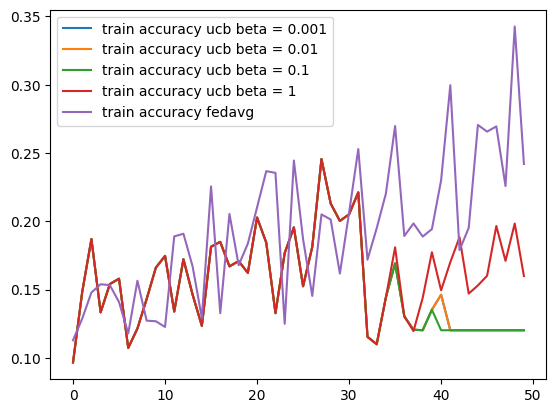

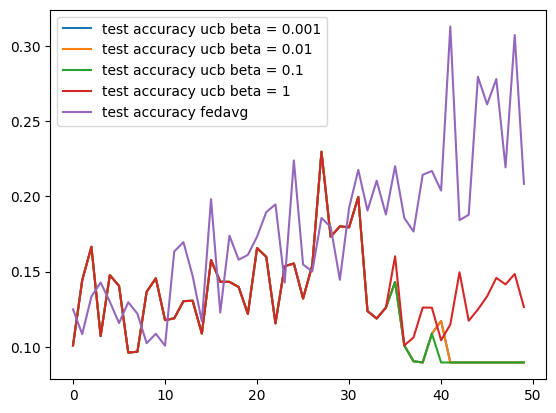

[]

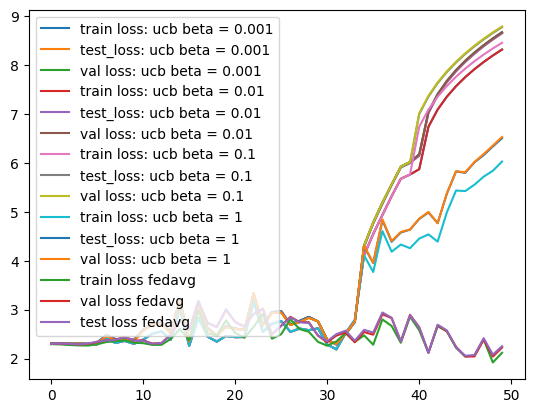

In [69]:
# for mu in mus:
#     plt.plot(train_acc[f'fedprox_{mu}'], label = 'train accuracy'+f' fedprox mu = {mu}')
for beta in betas:
    plt.plot(train_acc[f'ucb_{beta}'], label = 'train accuracy'+f' ucb beta = {beta}')
plt.plot(train_acc['fedavg'], label = 'train accuracy'+ f' fedavg')
plt.legend()
plt.show()

# for mu in mus:
#     plt.plot(test_acc[f'fedprox_{mu}'], label ='test accuracy'+f' fedprox mu = {mu}')
for beta in betas:
    plt.plot(test_acc[f'ucb_{beta}'], label = 'test accuracy'+f' ucb beta = {beta}')
plt.plot(test_acc['fedavg'], label ='test accuracy'+ f' fedavg')
plt.legend()
plt.show()

# for mu in mus:
#     plt.plot(train_loss[f'fedprox_{mu}'], label = 'train loss: '+f'fedprox_{mu}')
#     plt.plot(test_loss[f'fedprox_{mu}'], label = 'test_loss: '+f'fedprox_{mu}')
#     plt.plot(val_loss[f'fedprox_{mu}'], label = 'val loss: '+f'fedprox_{mu}')

for beta in betas:
    plt.plot(train_loss[f'ucb_{beta}'], label = 'train loss: '+f'ucb beta = {beta}')
    plt.plot(test_loss[f'ucb_{beta}'], label = 'test_loss: '+f'ucb beta = {beta}')
    plt.plot(val_loss[f'ucb_{beta}'], label = 'val loss: '+f'ucb beta = {beta}')


plt.plot(train_loss['fedavg'], label='train loss '+ 'fedavg')
plt.plot(val_loss['fedavg'], label='val loss '+ 'fedavg')
plt.plot(test_loss['fedavg'], label='test loss '+ 'fedavg')
plt.legend()
plt.plot()

In [61]:
(train_acc['fedavg'] - test_acc['fedavg'])*100

array([-0.12971451, -0.08188042, -0.16027719, -0.13583888, -0.09250249,
       -0.12144281, -0.16090629, -0.07807781, -0.10311097, -0.10145299,
       -0.16150692, -0.12647841, -0.15984915, -0.15098235, -0.16044546,
       -0.03925668, -0.1493333 , -0.17100481,  0.01467322,  0.07747999,
        0.07802272,  0.00575253,  0.04800592, -0.02371331, -0.02429941,
       -0.09159485,  0.00681494,  0.08909507,  0.17307794, -0.01263342,
       -0.06268024, -0.01099147,  0.1135574 ,  0.19473829,  0.15860685,
        0.10634135, -0.03715693,  0.05180864,  0.15910769,  0.14799479,
        0.1630322 ,  0.21142251,  0.1252105 ,  0.13686528,  0.10516936,
        0.1023782 ,  0.11293916,  0.10962159,  0.06845428,  0.09571014])

## Experimentation

In [11]:
dataset = "synthetic"
# dataset from ["cifar10", "mnist", "synthetic"]
num_clients = 100
random_seed = 10
alpha = 0.5
beta = 0.5  # needed for synthetic dataset

clients, server = initNetworkData(dataset, num_clients, random_seed, alpha, beta)
# wandb_config["dataset"] = dataset
# wandb_config["num_clients"] = num_clients
# wandb_config["alpha"] = alpha
# wandb_config["beta"] = beta
# wandb_config["clients"] = clients
# wandb_config["server"] = server

T = 101  # number of communications rounds
select_fraction = 0.03
# wandb_config["num_communication_rounds"] = T
# wandb_config["select_fraction"] = select_fraction
random_seed = 1

In [14]:
num_samples = [client.length for client in clients]
(np.mean(num_samples), np.std(num_samples))

(599.5, 152.29743924308116)

In [ ]:
acc_fedprox = {}
mus = [0.001, 0.01, 0.1, 1, 10, 100]
for mu in mus:
  acc_fedprox[mu], loss_fedprox[mu] = fedprox_runs(mu, runs)

In [12]:
# initialise some dataset split
# run fedavg
# run power of choice
acc_fedavg = fedavg_runs(10)

decay_factor = 0.9
acc_poc = poc_runs(0.9, 10)

  0%|          | 0/101 [00:03<?, ?it/s]


KeyboardInterrupt: ignored

In [ ]:
plt.plot(acc_fedavg, label = 'fedavg')

plt.plot(acc_poc, label = 'poc')
plt.legend()
plt.show()

In [19]:
# poc runs
runs = 10
for run in range(runs):
    clients, server = initNetworkData(dataset, num_clients, run, alpha, beta)
    accuracy_list_poc, val_loss_poc, test_loss_poc, client_accuracies_poc = power_of_choice_run(
        deepcopy(clients),
        deepcopy(server),
        select_fraction,
        T,
        decay_factor=1,
        random_seed=random_seed,
        E = 1
    )
    accuracy_list_fedavg, val_loss_fedavg, test_loss_fedavg, client_accuracies_fedavg = fed_avg_run(
        deepcopy(clients),
        deepcopy(server),
        select_fraction,
        T,
        random_seed=run,
        E = 1
    )
    accuracy_list_fedprox, val_loss_fedprox, test_loss_fedprox, client_accuracies_fedprox = fed_prox_run(
            deepcopy(clients),
            deepcopy(server),
            select_fraction,
            T,
            mu=mu,
            random_seed=random_seed,
        )
    accuracy_list_poc = np.array(accuracy_list_poc)
    accuracy_list_fedavg = np.array(accuracy_list_fedavg)

    val_loss_poc = np.array(val_loss_poc)
    val_loss_fedavg = np.array(val_loss_fedavg)

    test_loss_poc = np.array(test_loss_poc)
    test_loss_fedavg = np.array(test_loss_fedavg)

    client_accuracies_poc = np.array([np.array(x) for x in client_accuracies_poc])
    client_accuracies_fedavg = np.array([np.array(x) for x in client_accuracies_fedavg])

    weights = np.array([client.length for client in clients])
    weights = weights/np.sum(weights)
    train_accuracy_poc = weights @ client_accuracies_poc
    train_accuracy_fedavg = weights @ client_accuracies_fedavg

    if run == 0:
        avg_accuracy_list_fedavg = deepcopy(accuracy_list_fedavg)
        avg_accuracy_list_poc = deepcopy(accuracy_list_poc)

        avg_val_loss_poc = deepcopy(val_loss_poc)
        avg_test_loss_poc = deepcopy(test_loss_poc)

        avg_val_loss_fedavg = deepcopy(val_loss_fedavg)
        avg_test_loss_fedavg = deepcopy(test_loss_fedavg)

        avg_client_accuracies_poc = [deepcopy(x) for x in client_accuracies_poc]
        avg_client_accuracies_fedavg = [deepcopy(x) for x in client_accuracies_fedavg]

        avg_train_accuracy_poc = deepcopy(train_accuracy_poc)
        avg_train_accuracy_fedavg = deepcopy(train_accuracy_fedavg)

    avg_accuracy_list_fedavg = (run * avg_accuracy_list_fedavg + accuracy_list_fedavg) / (run + 1)
    avg_accuracy_list_poc = (run * avg_accuracy_list_poc + accuracy_list_poc) / (run + 1)

    avg_val_loss_poc = (run * avg_val_loss_poc + val_loss_poc) / (run + 1)
    avg_test_loss_poc = (run * avg_test_loss_poc + test_loss_poc) / (run + 1)

    avg_val_loss_fedavg = (run * avg_val_loss_fedavg + val_loss_fedavg) / (run + 1)
    avg_test_loss_fedavg = (run * avg_test_loss_fedavg + test_loss_fedavg) / (run + 1)

    avg_client_accuracies_poc = [(run*avg_client_accuracies_poc[i] + client_accuracies_poc[i])/(run + 1) for i in range(num_clients)]
    avg_client_accuracies_fedavg = [(run*avg_client_accuracies_fedavg[i] + client_accuracies_fedavg[i])/(run + 1) for i in range(num_clients)]

    avg_train_accuracy_poc = (run*avg_train_accuracy_poc + train_accuracy_poc)/(run+1)
    avg_train_accuracy_fedavg = (run*avg_train_accuracy_fedavg + train_accuracy_fedavg)/(run+1)




files already downloaded


100%|██████████| 101/101 [00:12<00:00,  8.00it/s]


files already downloaded


100%|██████████| 101/101 [00:12<00:00,  7.91it/s]


files already downloaded


100%|██████████| 101/101 [00:13<00:00,  7.62it/s]


files already downloaded


100%|██████████| 101/101 [00:12<00:00,  8.17it/s]


files already downloaded


100%|██████████| 101/101 [00:11<00:00,  8.43it/s]


files already downloaded


100%|██████████| 101/101 [00:11<00:00,  8.44it/s]


files already downloaded


100%|██████████| 101/101 [00:11<00:00,  8.97it/s]


files already downloaded


100%|██████████| 101/101 [00:11<00:00,  8.79it/s]


files already downloaded


100%|██████████| 101/101 [00:10<00:00,  9.51it/s]


files already downloaded


100%|██████████| 101/101 [00:11<00:00,  8.99it/s]


In [14]:
avg_train_accuracy_fedavg - avg_accuracy_list_fedavg

array([-8.00775985e-04,  8.59538803e-03,  2.94331432e-03,  2.26746230e-03,
        6.76697229e-03,  8.14333986e-03,  5.32489874e-03, -2.42824539e-03,
       -6.74464599e-03, -2.18818779e-03, -6.21568038e-03, -1.70755056e-03,
       -6.14235717e-03, -7.25063361e-03, -6.02293521e-03, -1.41845317e-03,
       -4.22168628e-03, -2.42188384e-03, -5.22248485e-03, -1.01968302e-03,
       -1.29935418e-03, -3.21609062e-03, -3.35671928e-03, -1.51461018e-03,
       -2.59412543e-03, -1.84780235e-04, -7.41460804e-04, -6.17214606e-04,
       -1.63900489e-03, -3.48787435e-03,  1.21527305e-05, -1.38592430e-03,
       -3.17118608e-03, -1.93147564e-03, -3.18480161e-03, -2.07820350e-03,
       -5.88147094e-04,  3.06665261e-04, -1.43999901e-03, -1.66093947e-03,
       -7.93596499e-04, -7.57410144e-04, -1.93330040e-03, -5.97999566e-04,
        4.33470358e-04, -7.79551038e-04, -2.37137978e-03, -3.96221924e-04,
        1.47297760e-04, -2.34701333e-04, -2.62716835e-04, -1.05484667e-03,
        5.50166605e-05,  

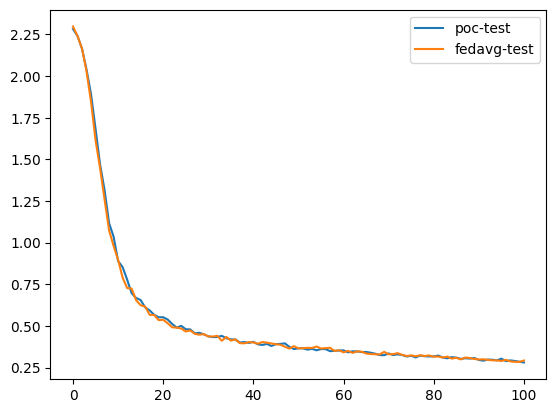

In [18]:
plt.plot(avg_test_loss_poc,label='poc-test')
plt.plot(avg_test_loss_fedavg,label='fedavg-test')
# plt.plot(avg_val_loss_poc,label='poc-val')
# plt.plot(avg_val_loss_fedavg,label='fedavg-val')
plt.legend()
plt.show()

## Hyperparameter Search

In [ ]:
"""
Hyperparameter search starts here
"""

dirichlet_alpha = alpha
synthetic_alpha = alpha
synthetic_beta = beta

# UCB search

beta_vals = [1e-1, 1, 1e1, 1e2]
accuracies_ucb = {}
for beta in beta_vals:
    accuracies_ucb[beta] = ucb_runs(beta, 3)

method = "ucb"
accuracies_summary = accuracies_ucb

if dataset in ["mnist", "cifar10"]:
    with open(
        f"./results/{method}_{dataset}_{num_clients}_{random_seed}_{dirichlet_alpha}.pickle",
        "wb",
    ) as f:
        pickle.dump(accuracies_summary, f)
else:
    with open(
        f"./results/{method}_{dataset}_{num_clients}_{random_seed}_{synthetic_alpha}_{synthetic_beta}.pickle",
        "wb",
    ) as f:
        pickle.dump(accuracies_summary, f)


# S-FedAvg search

alpha_vals = np.arange(0.1, 1, 0.2)
beta_vals = np.arange(0.1, 1, 0.2)
accuracies_sfedavg = {}
for alpha in alpha_vals:
    beta = 1 - alpha
    accuracies_sfedavg[(alpha, beta)] = sfedavg_runs(alpha, beta, 3)

method = "sfedavg"
accuracies_summary = accuracies_sfedavg

if dataset in ["mnist", "cifar10"]:
    with open(
        f"./results/{method}_{dataset}_{num_clients}_{random_seed}_{dirichlet_alpha}.pickle",
        "wb",
    ) as f:
        pickle.dump(accuracies_summary, f)
else:
    with open(
        f"./results/{method}_{dataset}_{num_clients}_{random_seed}_{synthetic_alpha}_{synthetic_beta}.pickle",
        "wb",
    ) as f:
        pickle.dump(accuracies_summary, f)

# FedAvg

accuracies_fedavg = fedavg_runs(5)
method = "fedavg"
accuracies_summary = accuracies_fedavg

if dataset in ["mnist", "cifar10"]:
    with open(
        f"./results/{method}_{dataset}_{num_clients}_{random_seed}_{dirichlet_alpha}.pickle",
        "wb",
    ) as f:
        pickle.dump(accuracies_summary, f)
else:
    with open(
        f"./results/{method}_{dataset}_{num_clients}_{random_seed}_{synthetic_alpha}_{synthetic_beta}.pickle",
        "wb",
    ) as f:
        pickle.dump(accuracies_summary, f)

# Power-of-Choice

decay_factors = [1, 0.99, 0.95, 0.9, 0.8]
accuracies_poc = {}
for decay_factor in decay_factors:
    accuracies_poc[decay_factor] = poc_runs(decay_factor, 3)

method = "poc"
accuracies_summary = accuracies_poc

if dataset in ["mnist", "cifar10"]:
    with open(
        f"./results/{method}_{dataset}_{num_clients}_{random_seed}_{dirichlet_alpha}.pickle",
        "wb",
    ) as f:
        pickle.dump(accuracies_summary, f)
else:
    with open(
        f"./results/{method}_{dataset}_{num_clients}_{random_seed}_{synthetic_alpha}_{synthetic_beta}.pickle",
        "wb",
    ) as f:
        pickle.dump(accuracies_summary, f)

# FedProx

mu_vals = [10**i for i in range(-3, 3)]
accuracies_fedprox = {}
for mu in mu_vals:
    accuracies_fedprox[mu] = fedprox_runs(mu, 3)

method = "fedprox"
accuracies_summary = accuracies_fedprox

if dataset in ["mnist", "cifar10"]:
    with open(
        f"./results/{method}_{dataset}_{num_clients}_{random_seed}_{dirichlet_alpha}.pickle",
        "wb",
    ) as f:
        pickle.dump(accuracies_summary, f)
else:
    with open(
        f"./results/{method}_{dataset}_{num_clients}_{random_seed}_{synthetic_alpha}_{synthetic_beta}.pickle",
        "wb",
    ) as f:
        pickle.dump(accuracies_summary, f)


"""""""""""""""""
Hyperparameter search ends here
"""""""""""""""""



## Extra Plotting Code

In [ ]:

sns.heatmap(draws_heatmap).set(title="draws")
plt.show()
sns.heatmap(shapley_heatmap).set(title="shapley values")
plt.show()
sns.heatmap(selection_heatmap).set(title="selections")
plt.show()

plt.plot(accuracy_ucb, label="UCB")
plt.plot(accuracy_fedavg, label="fedavg")
plt.legend()
plt.show()

for i in range(5):
    accuracy_poc, _, _ = power_of_choice_run(
        deepcopy(clients),
        deepcopy(server),
        select_fraction,
        T,
        decay_factor=0.95,
        random_seed=i,
    )

    accuracy_poc_nodecay, _, _ = power_of_choice_run(
        deepcopy(clients),
        deepcopy(server),
        select_fraction,
        T,
        decay_factor=1,
        random_seed=i,
    )

(
    accuracy,
    val_loss,
    test_loss,
    client_losses_init,
    client_losses_final,
) = fed_avg_run_analysis(
    deepcopy(clients), deepcopy(server), select_fraction, T, random_seed=1
)

for i in range(5):
    accuracy_prox, _, _ = fed_prox_run(
        deepcopy(clients), deepcopy(server), select_fraction, T, mu=0.1, random_seed=i
    )
    if i == 0:
        accuracy_avg = np.array(accuracy)
        accuracy_prox_avg = np.array(accuracy_prox)
        accuracy_poc_avg = np.array(accuracy_poc)
        accuracy_poc_nodecay_avg = np.array(accuracy_poc_nodecay)
    else:
        accuracy_avg = accuracy_avg * (i / (i + 1)) + np.array(accuracy) * (1 / (i + 1))
        accuracy_prox_avg = accuracy_prox_avg * (i / (i + 1)) + np.array(
            accuracy_prox
        ) * (1 / (i + 1))
        accuracy_poc_avg = accuracy_poc_avg * (i / (i + 1)) + np.array(accuracy_poc) * (
            1 / (i + 1)
        )
        accuracy_poc_nodecay_avg = accuracy_poc_nodecay_avg * (i / (i + 1)) + np.array(
            accuracy_poc_nodecay
        ) * (1 / (i + 1))



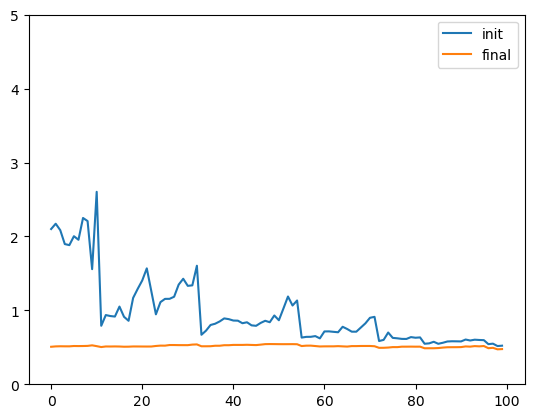

In [ ]:
i = 10
plt.plot(client_losses_init[i], label = 'init')
plt.plot(client_losses_final[i], label = 'final')
plt.ylim((0,5))
plt.legend()

In [ ]:
plt.plot(val_loss, label="val loss")
plt.plot(test_loss, label="test loss")
for i in range(num_clients):
    plt.plot(client_losses_init[i], label=f"client loss init {i}")

plt.legend()
plt.show()